In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.bandpass

In [2]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [3]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [4]:
data_total = pd.read_csv('/content/drive/MyDrive/model_2s/total_band.csv', header=None)

In [5]:
data_total

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
1,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.071806,-0.071741,-0.071302,-0.070367,-0.068861,-0.066758,-0.064085,-0.060936,-0.057487,1.0
2,-0.054004,-0.050825,-0.048322,-0.046824,-0.046532,-0.047445,-0.049330,-0.051735,-0.054058,-0.055645,...,0.009824,0.013030,0.016239,0.019380,0.022418,0.025327,0.028062,0.030516,0.032514,1.0
3,0.053295,0.053439,0.055066,0.059409,0.067278,0.078961,0.094216,0.112361,0.132422,0.153321,...,0.388900,0.382609,0.370062,0.351265,0.326472,0.296135,0.260876,0.221465,0.178820,1.0
4,0.134007,0.088232,0.042803,-0.000932,-0.041686,-0.078336,-0.110032,-0.136271,-0.156943,-0.172313,...,-0.113220,-0.141579,-0.164040,-0.180986,-0.193086,-0.201181,-0.206146,-0.208783,-0.209743,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-0.087605,-0.069234,-0.058444,-0.053914,-0.053427,-0.054525,-0.055053,-0.053525,-0.049262,-0.042344,...,-0.020100,-0.018824,-0.018132,-0.018247,-0.019303,-0.021303,-0.024082,-0.027314,-0.030559,100.0
17996,-0.033347,-0.035287,-0.036169,-0.036014,-0.035070,-0.033744,-0.032503,-0.031760,-0.031802,-0.032746,...,-0.060069,-0.061489,-0.061986,-0.061385,-0.059834,-0.057803,-0.055972,-0.055062,-0.055631,100.0
17997,-0.076867,-0.083002,-0.088128,-0.091454,-0.092582,-0.091623,-0.089189,-0.086281,-0.084051,-0.083490,...,-0.053679,-0.057318,-0.059515,-0.061043,-0.062554,-0.064528,-0.067243,-0.070758,-0.074902,100.0
17998,-0.079288,-0.083358,-0.086464,-0.087995,-0.087513,-0.084880,-0.080336,-0.074488,-0.068211,-0.062467,...,-0.048461,-0.044455,-0.041670,-0.040185,-0.039799,-0.040120,-0.040694,-0.041169,-0.041409,100.0


## 데이터 전체 섞기

In [6]:
data_total=data_total.sample(frac=1)

In [7]:
data_train=data_total.iloc[0:14400, :]
data_val=data_total.iloc[14400:16200, :]
data_test=data_total.iloc[16200:18000,:]

In [8]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
7907,-0.017906,-0.016111,-0.015265,-0.015048,-0.015061,-0.014937,-0.014443,-0.013542,-0.012380,-0.011228,...,0.017852,0.005363,-0.004584,-0.011813,-0.016382,-0.018636,-0.019204,-0.018925,-0.018720,44.0
11143,-0.118654,-0.121925,-0.126439,-0.131408,-0.135973,-0.139351,-0.140978,-0.140594,-0.138273,-0.134396,...,0.459992,0.467328,0.469964,0.467341,0.458892,0.444103,0.422623,0.394386,0.359716,62.0
5909,-0.081073,-0.083194,-0.084811,-0.085956,-0.086619,-0.086742,-0.086232,-0.084994,-0.082948,-0.080048,...,-0.037322,-0.035238,-0.036388,-0.040418,-0.046553,-0.053785,-0.061092,-0.067619,-0.072789,33.0
11356,-0.165740,-0.152825,-0.133079,-0.111981,-0.093823,-0.081138,-0.074583,-0.073233,-0.075129,-0.077930,...,-0.055745,-0.066144,-0.071713,-0.067951,-0.050901,-0.018156,0.030236,0.091215,0.158715,64.0
8679,-0.008112,-0.001494,0.002451,0.001650,-0.004908,-0.016943,-0.032950,-0.050519,-0.066840,-0.079277,...,-0.067563,-0.069860,-0.071013,-0.071196,-0.070569,-0.069267,-0.067397,-0.065056,-0.062354,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649,0.000466,0.005334,0.009596,0.012806,0.014792,0.015685,0.015858,0.015806,0.015992,0.016739,...,-0.040887,-0.048713,-0.057635,-0.066352,-0.073594,-0.078350,-0.080013,-0.078441,-0.073937,49.0
938,-0.032009,-0.027885,-0.021962,-0.014614,-0.006394,0.002082,0.010239,0.017626,0.023943,0.029020,...,-0.022558,0.029429,0.089977,0.151508,0.205117,0.242187,0.256085,0.243552,0.205435,6.0
15953,0.363541,0.358640,0.350826,0.340031,0.326239,0.309534,0.290130,0.268378,0.244732,0.219710,...,-0.053166,-0.051262,-0.051134,-0.053391,-0.057984,-0.064026,-0.069738,-0.072595,-0.069675,89.0
1287,0.023535,0.018301,0.013760,0.010491,0.008849,0.008923,0.010539,0.013317,0.016758,0.020343,...,0.110350,0.105924,0.099017,0.089660,0.078087,0.064757,0.050327,0.035595,0.021386,8.0


## 전처리

In [9]:
y_train = to_categorical(data_train[512])
y_test = to_categorical(data_test[512])
y_val = to_categorical(data_val[512])
# y_train = to_categorical(arr)
# y_test = to_categorical(arr_t)
# y_val = to_categorical(arr_v)
y_train[14399]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [10]:
data_train.drop([512], axis=1, inplace=True)
data_test.drop([512], axis=1, inplace=True)
data_val.drop([512], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
7907,-0.017906,-0.016111,-0.015265,-0.015048,-0.015061,-0.014937,-0.014443,-0.013542,-0.012380,-0.011228,...,0.032553,0.017852,0.005363,-0.004584,-0.011813,-0.016382,-0.018636,-0.019204,-0.018925,-0.018720
11143,-0.118654,-0.121925,-0.126439,-0.131408,-0.135973,-0.139351,-0.140978,-0.140594,-0.138273,-0.134396,...,0.448493,0.459992,0.467328,0.469964,0.467341,0.458892,0.444103,0.422623,0.394386,0.359716
5909,-0.081073,-0.083194,-0.084811,-0.085956,-0.086619,-0.086742,-0.086232,-0.084994,-0.082948,-0.080048,...,-0.042474,-0.037322,-0.035238,-0.036388,-0.040418,-0.046553,-0.053785,-0.061092,-0.067619,-0.072789
11356,-0.165740,-0.152825,-0.133079,-0.111981,-0.093823,-0.081138,-0.074583,-0.073233,-0.075129,-0.077930,...,-0.044651,-0.055745,-0.066144,-0.071713,-0.067951,-0.050901,-0.018156,0.030236,0.091215,0.158715
8679,-0.008112,-0.001494,0.002451,0.001650,-0.004908,-0.016943,-0.032950,-0.050519,-0.066840,-0.079277,...,-0.063964,-0.067563,-0.069860,-0.071013,-0.071196,-0.070569,-0.069267,-0.067397,-0.065056,-0.062354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649,0.000466,0.005334,0.009596,0.012806,0.014792,0.015685,0.015858,0.015806,0.015992,0.016739,...,-0.035229,-0.040887,-0.048713,-0.057635,-0.066352,-0.073594,-0.078350,-0.080013,-0.078441,-0.073937
938,-0.032009,-0.027885,-0.021962,-0.014614,-0.006394,0.002082,0.010239,0.017626,0.023943,0.029020,...,-0.060928,-0.022558,0.029429,0.089977,0.151508,0.205117,0.242187,0.256085,0.243552,0.205435
15953,0.363541,0.358640,0.350826,0.340031,0.326239,0.309534,0.290130,0.268378,0.244732,0.219710,...,-0.055847,-0.053166,-0.051262,-0.051134,-0.053391,-0.057984,-0.064026,-0.069738,-0.072595,-0.069675
1287,0.023535,0.018301,0.013760,0.010491,0.008849,0.008923,0.010539,0.013317,0.016758,0.020343,...,0.112414,0.110350,0.105924,0.099017,0.089660,0.078087,0.064757,0.050327,0.035595,0.021386


In [11]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [12]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(14400, 512)
(1800, 512)
(1800, 512)
(14400, 101)
(1800, 101)
(1800, 101)


In [13]:
# X_train = X_train.reshape(1, 256, 24000)
# X_test = X_test.reshape(1, 256, 6000)
# X_val = X_val.reshape(1, 256, 6000)
X_train = X_train.reshape(14400, 512, 1)
X_test = X_test.reshape(1800, 512, 1)
X_val = X_val.reshape(1800, 512, 1)
X_train.shape, X_test.shape, X_val.shape

((14400, 512, 1), (1800, 512, 1), (1800, 512, 1))

## cnn-lstm 모델

In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 256, 64)           448       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                     

## cnn-gru 모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=(256, 1)))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(4))
model.add(CuDNNGRU(64))

model.add(Dropout(0.1))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 256, 64)           448       
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 64)          0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 cu_dnngru_4 (CuDNNGRU)      (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 101)              

## gru모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(GRU(units=150, return_sequences=True, input_shape=(512,1))) #shape[1]=열
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 512, 150)          68850     
                                                                 
 gru_1 (GRU)                 (None, 512, 50)           30300     
                                                                 
 gru_2 (GRU)                 (None, 512, 50)           15300     
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dropout (Dropout)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 101)               2585701   
                                                                 
Total params: 2,700,151
Trainable params: 2,700,151
Non-

## LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## RNN모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 256, 100)          10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 256, 50)           7550      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 50)           5050      
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,315,701
Trainable params: 1,315,701
No

## CNN

In [29]:
def model():
  model = Sequential()
  model.add(Conv1D(512, 8, padding='same', activation='relu', input_shape= (512,1)))
  model.add(MaxPooling1D())
  model.add(Conv1D(512, 8, padding='same', activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(128, 8, padding='same',activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same',activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(101, activation='softmax')) # activation='softmax'

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [30]:
model=model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 512, 512)          4608      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 256, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 256, 512)          2097664   
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 128, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 128, 128)          524416    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 64, 128)         

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size =1024, epochs = 1000, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/1000
15/15 [==============================] - 16s 1s/step - loss: 0.0098 - accuracy: 0.0172 - val_loss: 0.0098 - val_accuracy: 0.0083
Epoch 2/1000
15/15 [==============================] - 12s 809ms/step - loss: 0.0097 - accuracy: 0.0334 - val_loss: 0.0098 - val_accuracy: 0.0333
Epoch 3/1000
15/15 [==============================] - 12s 822ms/step - loss: 0.0094 - accuracy: 0.0719 - val_loss: 0.0098 - val_accuracy: 0.0328
Epoch 4/1000
15/15 [==============================] - 13s 836ms/step - loss: 0.0087 - accuracy: 0.1956 - val_loss: 0.0097 - val_accuracy: 0.0133
Epoch 5/1000
15/15 [==============================] - 13s 832ms/step - loss: 0.0076 - accuracy: 0.3649 - val_loss: 0.0099 - val_accuracy: 0.0267
Epoch 6/1000
15/15 [==============================] - 12s 821ms/step - loss: 0.0064 - accuracy: 0.4980 - val_loss: 0.0100 - val_accuracy: 0.0472
Epoch 7/1000
15/15 [==============================] - 12s 814ms/step - loss: 0.0052 - accuracy: 0.6268 - val_loss: 0.0101 - val_accur

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model.save('cnn_bandpass_2s.h5')

## 그래프 분석

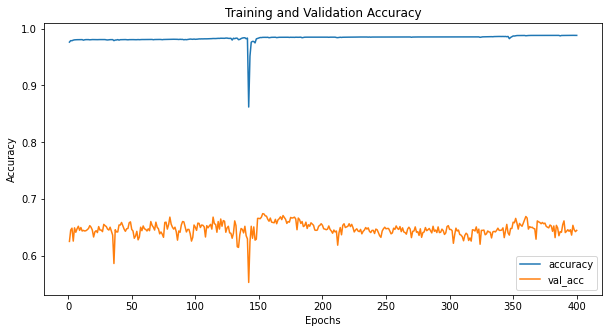

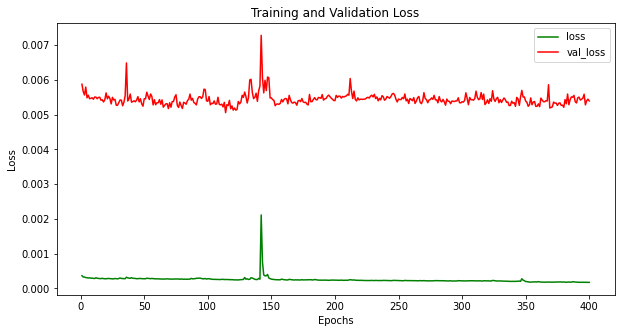

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 2s 9ms/step


array([[44,  0,  0, ...,  0,  0,  0],
       [ 0, 57,  0, ...,  0,  0,  0],
       [ 0,  0, 65, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 67,  0],
       [ 0,  0,  0, ...,  0,  0, 57]])

In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       59.0
1       68.0
2       72.0
3        2.0
4       57.0
        ... 
5995     3.0
5996    87.0
5997    40.0
5998    68.0
5999    37.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
# ch1 = pd.DataFrame(np.rint(y_pred))
# for i in range(1,101):
#   ch1.loc[ch1[i] == 1.0 , 'pred'] = i 

 
#predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,59.0
1,68.0
2,72.0
3,2.0
4,57.0
...,...
5995,3.0
5996,87.0
5997,40.0
5998,68.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
30,0.001909,0.008317,0.014489,0.020412,0.025995,0.031137,0.035801,0.040075,0.044195,0.048538,...,0.044631,0.050399,0.057432,0.066046,0.076371,0.088327,0.101648,85.0,36.0,no
46,0.096114,0.095362,0.095047,0.095447,0.096676,0.098677,0.101247,0.104083,0.106844,0.109202,...,-0.004398,-0.008214,-0.013081,-0.019006,-0.025674,-0.032320,-0.037693,83.0,80.0,no
54,-0.041972,-0.048778,-0.055266,-0.061636,-0.067728,-0.073065,-0.076978,-0.078796,-0.078050,-0.074630,...,-0.102289,-0.108650,-0.114708,-0.119718,-0.122885,-0.123496,-0.121095,20.0,71.0,no
55,0.050686,0.056807,0.061922,0.066330,0.070463,0.074831,0.079964,0.086349,0.094365,0.104239,...,0.125449,0.136371,0.147691,0.159697,0.172642,0.186692,0.201860,41.0,50.0,no
71,-0.511413,-0.507140,-0.469849,-0.408462,-0.333769,-0.256404,-0.185178,-0.126038,-0.081724,-0.052058,...,0.031533,0.034874,0.038518,0.042180,0.045745,0.049241,0.052764,4.0,93.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.005315,-0.043084,-0.083200,-0.110473,-0.122973,-0.121490,-0.109050,-0.090022,-0.069069,-0.050204,...,-0.027012,-0.029614,-0.031356,-0.033020,-0.035244,-0.038329,-0.042129,95.0,23.0,no
5981,-0.005281,-0.018280,-0.031669,-0.042939,-0.050464,-0.053648,-0.052817,-0.048958,-0.043371,-0.037307,...,-0.016826,-0.013496,-0.011275,-0.010594,-0.011830,-0.015208,-0.020697,52.0,40.0,no
5992,-0.084734,-0.091664,-0.098196,-0.101411,-0.098148,-0.085744,-0.062829,-0.030004,0.009808,0.051498,...,0.072150,0.081214,0.090895,0.101388,0.112932,0.125713,0.139775,100.0,83.0,no
5994,0.008461,0.011468,0.012707,0.012096,0.009875,0.006558,0.002841,-0.000513,-0.002782,-0.003375,...,-0.048723,-0.051678,-0.052151,-0.050205,-0.046318,-0.041326,-0.036264,95.0,49.0,no


# 2.highpass

In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_total = pd.read_csv('/content/drive/MyDrive/model_2s/total_band.csv', header=None)

In [ ]:
data_total

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
1,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.071806,-0.071741,-0.071302,-0.070367,-0.068861,-0.066758,-0.064085,-0.060936,-0.057487,1.0
2,-0.054004,-0.050825,-0.048322,-0.046824,-0.046532,-0.047445,-0.049330,-0.051735,-0.054058,-0.055645,...,0.009824,0.013030,0.016239,0.019380,0.022418,0.025327,0.028062,0.030516,0.032514,1.0
3,0.053295,0.053439,0.055066,0.059409,0.067278,0.078961,0.094216,0.112361,0.132422,0.153321,...,0.388900,0.382609,0.370062,0.351265,0.326472,0.296135,0.260876,0.221465,0.178820,1.0
4,0.134007,0.088232,0.042803,-0.000932,-0.041686,-0.078336,-0.110032,-0.136271,-0.156943,-0.172313,...,-0.113220,-0.141579,-0.164040,-0.180986,-0.193086,-0.201181,-0.206146,-0.208783,-0.209743,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-0.087605,-0.069234,-0.058444,-0.053914,-0.053427,-0.054525,-0.055053,-0.053525,-0.049262,-0.042344,...,-0.020100,-0.018824,-0.018132,-0.018247,-0.019303,-0.021303,-0.024082,-0.027314,-0.030559,100.0
17996,-0.033347,-0.035287,-0.036169,-0.036014,-0.035070,-0.033744,-0.032503,-0.031760,-0.031802,-0.032746,...,-0.060069,-0.061489,-0.061986,-0.061385,-0.059834,-0.057803,-0.055972,-0.055062,-0.055631,100.0
17997,-0.076867,-0.083002,-0.088128,-0.091454,-0.092582,-0.091623,-0.089189,-0.086281,-0.084051,-0.083490,...,-0.053679,-0.057318,-0.059515,-0.061043,-0.062554,-0.064528,-0.067243,-0.070758,-0.074902,100.0
17998,-0.079288,-0.083358,-0.086464,-0.087995,-0.087513,-0.084880,-0.080336,-0.074488,-0.068211,-0.062467,...,-0.048461,-0.044455,-0.041670,-0.040185,-0.039799,-0.040120,-0.040694,-0.041169,-0.041409,100.0


## 데이터 전체 섞기

In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:14400, :]
data_val=data_total.iloc[14400:16200, :]
data_test=data_total.iloc[16200:18000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
12271,0.011548,0.008488,0.003629,-0.001850,-0.006585,-0.009308,-0.009111,-0.005618,0.000966,0.009941,...,-0.092055,-0.088837,-0.083735,-0.079199,-0.078123,-0.083104,-0.095548,-0.114823,-0.137707,69.0
13301,-0.104636,-0.105467,-0.105061,-0.104101,-0.103201,-0.102838,-0.103294,-0.104638,-0.106737,-0.109303,...,-0.434067,-0.397023,-0.336771,-0.266172,-0.196964,-0.138022,-0.094467,-0.067628,-0.055680,74.0
5332,-0.012883,-0.035286,-0.053552,-0.067500,-0.077205,-0.082961,-0.085256,-0.084736,-0.082161,-0.078343,...,0.017269,0.112567,0.214263,0.308861,0.382117,0.421823,0.420427,0.376841,0.296926,30.0
1880,-0.076507,-0.079781,-0.081961,-0.083390,-0.084599,-0.086177,-0.088622,-0.092196,-0.096821,-0.102044,...,-0.130756,-0.132104,-0.134025,-0.136428,-0.139013,-0.141338,-0.142913,-0.143320,-0.142310,11.0
973,-0.094721,-0.093787,-0.091414,-0.087818,-0.083370,-0.078623,-0.074293,-0.071172,-0.069985,-0.071207,...,0.006448,0.005379,0.003184,-0.000138,-0.004271,-0.008627,-0.012468,-0.015068,-0.015879,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7058,-0.084069,-0.052032,-0.027035,-0.011892,-0.006866,-0.010255,-0.019178,-0.030371,-0.040835,-0.048291,...,0.080720,0.094054,0.106730,0.118500,0.129080,0.138144,0.145345,0.150342,0.152823,40.0
3680,-0.044854,-0.041024,-0.038506,-0.037514,-0.038143,-0.040339,-0.043899,-0.048501,-0.053753,-0.059266,...,-0.028767,-0.040588,-0.050093,-0.057467,-0.063021,-0.067091,-0.069939,-0.071706,-0.072419,21.0
16151,-0.037901,-0.043779,-0.049116,-0.053866,-0.058078,-0.061812,-0.065067,-0.067736,-0.069620,-0.070469,...,-0.048270,-0.052330,-0.054928,-0.055776,-0.054865,-0.052461,-0.049072,-0.045366,-0.042066,90.0
4129,0.000499,0.006756,0.012140,0.016098,0.018497,0.019539,0.019597,0.019024,0.018025,0.016620,...,0.106401,0.094250,0.080913,0.067193,0.053784,0.041198,0.029706,0.019338,0.009902,23.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[512])
y_test = to_categorical(data_test[512])
y_val = to_categorical(data_val[512])
# y_train = to_categorical(arr)
# y_test = to_categorical(arr_t)
# y_val = to_categorical(arr_v)
y_train[14399]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([512], axis=1, inplace=True)
data_test.drop([512], axis=1, inplace=True)
data_val.drop([512], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
12271,0.011548,0.008488,0.003629,-0.001850,-0.006585,-0.009308,-0.009111,-0.005618,0.000966,0.009941,...,-0.091861,-0.092055,-0.088837,-0.083735,-0.079199,-0.078123,-0.083104,-0.095548,-0.114823,-0.137707
13301,-0.104636,-0.105467,-0.105061,-0.104101,-0.103201,-0.102838,-0.103294,-0.104638,-0.106737,-0.109303,...,-0.436294,-0.434067,-0.397023,-0.336771,-0.266172,-0.196964,-0.138022,-0.094467,-0.067628,-0.055680
5332,-0.012883,-0.035286,-0.053552,-0.067500,-0.077205,-0.082961,-0.085256,-0.084736,-0.082161,-0.078343,...,-0.061198,0.017269,0.112567,0.214263,0.308861,0.382117,0.421823,0.420427,0.376841,0.296926
1880,-0.076507,-0.079781,-0.081961,-0.083390,-0.084599,-0.086177,-0.088622,-0.092196,-0.096821,-0.102044,...,-0.129850,-0.130756,-0.132104,-0.134025,-0.136428,-0.139013,-0.141338,-0.142913,-0.143320,-0.142310
973,-0.094721,-0.093787,-0.091414,-0.087818,-0.083370,-0.078623,-0.074293,-0.071172,-0.069985,-0.071207,...,0.006683,0.006448,0.005379,0.003184,-0.000138,-0.004271,-0.008627,-0.012468,-0.015068,-0.015879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7058,-0.084069,-0.052032,-0.027035,-0.011892,-0.006866,-0.010255,-0.019178,-0.030371,-0.040835,-0.048291,...,0.066962,0.080720,0.094054,0.106730,0.118500,0.129080,0.138144,0.145345,0.150342,0.152823
3680,-0.044854,-0.041024,-0.038506,-0.037514,-0.038143,-0.040339,-0.043899,-0.048501,-0.053753,-0.059266,...,-0.014650,-0.028767,-0.040588,-0.050093,-0.057467,-0.063021,-0.067091,-0.069939,-0.071706,-0.072419
16151,-0.037901,-0.043779,-0.049116,-0.053866,-0.058078,-0.061812,-0.065067,-0.067736,-0.069620,-0.070469,...,-0.043265,-0.048270,-0.052330,-0.054928,-0.055776,-0.054865,-0.052461,-0.049072,-0.045366,-0.042066
4129,0.000499,0.006756,0.012140,0.016098,0.018497,0.019539,0.019597,0.019024,0.018025,0.016620,...,0.116555,0.106401,0.094250,0.080913,0.067193,0.053784,0.041198,0.029706,0.019338,0.009902


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(14400, 512)
(1800, 512)
(1800, 512)
(14400, 101)
(1800, 101)
(1800, 101)


In [ ]:
# X_train = X_train.reshape(1, 256, 24000)
# X_test = X_test.reshape(1, 256, 6000)
# X_val = X_val.reshape(1, 256, 6000)
X_train = X_train.reshape(14400, 512, 1)
X_test = X_test.reshape(1800, 512, 1)
X_val = X_val.reshape(1800, 512, 1)
X_train.shape, X_test.shape, X_val.shape

((14400, 512, 1), (1800, 512, 1), (1800, 512, 1))

## cnn-lstm 모델

In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 256, 64)           448       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                     

## cnn-gru 모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=(256, 1)))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(4))
model.add(CuDNNGRU(64))

model.add(Dropout(0.1))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 256, 64)           448       
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 64)          0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 cu_dnngru_4 (CuDNNGRU)      (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 101)              

## gru모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(GRU(units=150, return_sequences=True, input_shape=(512,1))) #shape[1]=열
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 512, 150)          68850     
                                                                 
 gru_4 (GRU)                 (None, 512, 50)           30300     
                                                                 
 gru_5 (GRU)                 (None, 512, 50)           15300     
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25600)             0         
                                                                 
 dense_1 (Dense)             (None, 101)               2585701   
                                                                 
Total params: 2,700,151
Trainable params: 2,700,151
No

## LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## RNN모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 256, 100)          10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 256, 50)           7550      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 50)           5050      
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,315,701
Trainable params: 1,315,701
No

## CNN

In [ ]:
def model():
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same', activation='relu', input_shape= (256,1)))
  model.add(MaxPooling1D())
  model.add(Conv1D(256, 8, padding='same', activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same',activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(101, activation='softmax')) # activation='softmax'

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size =1024, epochs = 400, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/400
15/15 [==============================] - 5s 345ms/step - loss: 3.6500e-04 - accuracy: 0.9764 - val_loss: 0.0059 - val_accuracy: 0.6256
Epoch 2/400
15/15 [==============================] - 5s 344ms/step - loss: 3.2755e-04 - accuracy: 0.9790 - val_loss: 0.0057 - val_accuracy: 0.6456
Epoch 3/400
15/15 [==============================] - 5s 346ms/step - loss: 3.2645e-04 - accuracy: 0.9788 - val_loss: 0.0056 - val_accuracy: 0.6489
Epoch 4/400
15/15 [==============================] - 5s 345ms/step - loss: 3.1191e-04 - accuracy: 0.9799 - val_loss: 0.0058 - val_accuracy: 0.6261
Epoch 5/400
15/15 [==============================] - 5s 345ms/step - loss: 3.0775e-04 - accuracy: 0.9803 - val_loss: 0.0055 - val_accuracy: 0.6494
Epoch 6/400
15/15 [==============================] - 5s 347ms/step - loss: 2.9940e-04 - accuracy: 0.9806 - val_loss: 0.0056 - val_accuracy: 0.6417
Epoch 7/400
15/15 [==============================] - 5s 347ms/step - loss: 3.0320e-04 - accuracy: 0.9806 - val_loss: 0

In [ ]:
model.evaluate(X_test, y_test)

57/57 [==============================] - 1s 17ms/step - loss: 0.0057 - accuracy: 0.6294


[0.0056536439806222916, 0.629444420337677]

## 그래프 분석

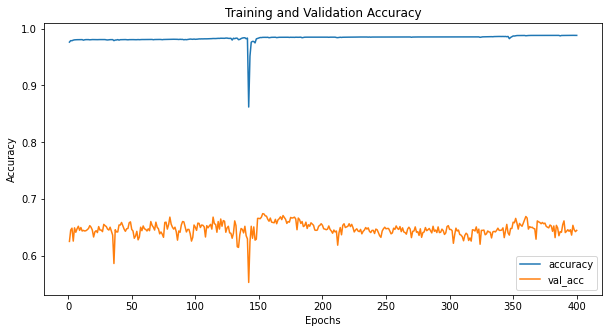

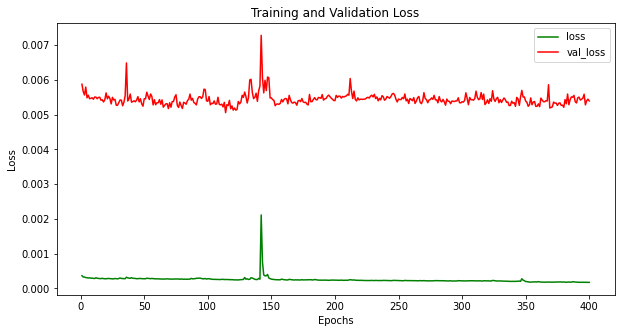

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 2s 9ms/step


array([[44,  0,  0, ...,  0,  0,  0],
       [ 0, 57,  0, ...,  0,  0,  0],
       [ 0,  0, 65, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 67,  0],
       [ 0,  0,  0, ...,  0,  0, 57]])

In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       59.0
1       68.0
2       72.0
3        2.0
4       57.0
        ... 
5995     3.0
5996    87.0
5997    40.0
5998    68.0
5999    37.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
# ch1 = pd.DataFrame(np.rint(y_pred))
# for i in range(1,101):
#   ch1.loc[ch1[i] == 1.0 , 'pred'] = i 

 
#predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,59.0
1,68.0
2,72.0
3,2.0
4,57.0
...,...
5995,3.0
5996,87.0
5997,40.0
5998,68.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
30,0.001909,0.008317,0.014489,0.020412,0.025995,0.031137,0.035801,0.040075,0.044195,0.048538,...,0.044631,0.050399,0.057432,0.066046,0.076371,0.088327,0.101648,85.0,36.0,no
46,0.096114,0.095362,0.095047,0.095447,0.096676,0.098677,0.101247,0.104083,0.106844,0.109202,...,-0.004398,-0.008214,-0.013081,-0.019006,-0.025674,-0.032320,-0.037693,83.0,80.0,no
54,-0.041972,-0.048778,-0.055266,-0.061636,-0.067728,-0.073065,-0.076978,-0.078796,-0.078050,-0.074630,...,-0.102289,-0.108650,-0.114708,-0.119718,-0.122885,-0.123496,-0.121095,20.0,71.0,no
55,0.050686,0.056807,0.061922,0.066330,0.070463,0.074831,0.079964,0.086349,0.094365,0.104239,...,0.125449,0.136371,0.147691,0.159697,0.172642,0.186692,0.201860,41.0,50.0,no
71,-0.511413,-0.507140,-0.469849,-0.408462,-0.333769,-0.256404,-0.185178,-0.126038,-0.081724,-0.052058,...,0.031533,0.034874,0.038518,0.042180,0.045745,0.049241,0.052764,4.0,93.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.005315,-0.043084,-0.083200,-0.110473,-0.122973,-0.121490,-0.109050,-0.090022,-0.069069,-0.050204,...,-0.027012,-0.029614,-0.031356,-0.033020,-0.035244,-0.038329,-0.042129,95.0,23.0,no
5981,-0.005281,-0.018280,-0.031669,-0.042939,-0.050464,-0.053648,-0.052817,-0.048958,-0.043371,-0.037307,...,-0.016826,-0.013496,-0.011275,-0.010594,-0.011830,-0.015208,-0.020697,52.0,40.0,no
5992,-0.084734,-0.091664,-0.098196,-0.101411,-0.098148,-0.085744,-0.062829,-0.030004,0.009808,0.051498,...,0.072150,0.081214,0.090895,0.101388,0.112932,0.125713,0.139775,100.0,83.0,no
5994,0.008461,0.011468,0.012707,0.012096,0.009875,0.006558,0.002841,-0.000513,-0.002782,-0.003375,...,-0.048723,-0.051678,-0.052151,-0.050205,-0.046318,-0.041326,-0.036264,95.0,49.0,no


# 3.lowpass

In [ ]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [ ]:
data_total = pd.read_csv('/content/drive/MyDrive/model_2s/total_band.csv', header=None)

In [ ]:
data_total

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
1,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.071806,-0.071741,-0.071302,-0.070367,-0.068861,-0.066758,-0.064085,-0.060936,-0.057487,1.0
2,-0.054004,-0.050825,-0.048322,-0.046824,-0.046532,-0.047445,-0.049330,-0.051735,-0.054058,-0.055645,...,0.009824,0.013030,0.016239,0.019380,0.022418,0.025327,0.028062,0.030516,0.032514,1.0
3,0.053295,0.053439,0.055066,0.059409,0.067278,0.078961,0.094216,0.112361,0.132422,0.153321,...,0.388900,0.382609,0.370062,0.351265,0.326472,0.296135,0.260876,0.221465,0.178820,1.0
4,0.134007,0.088232,0.042803,-0.000932,-0.041686,-0.078336,-0.110032,-0.136271,-0.156943,-0.172313,...,-0.113220,-0.141579,-0.164040,-0.180986,-0.193086,-0.201181,-0.206146,-0.208783,-0.209743,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-0.087605,-0.069234,-0.058444,-0.053914,-0.053427,-0.054525,-0.055053,-0.053525,-0.049262,-0.042344,...,-0.020100,-0.018824,-0.018132,-0.018247,-0.019303,-0.021303,-0.024082,-0.027314,-0.030559,100.0
17996,-0.033347,-0.035287,-0.036169,-0.036014,-0.035070,-0.033744,-0.032503,-0.031760,-0.031802,-0.032746,...,-0.060069,-0.061489,-0.061986,-0.061385,-0.059834,-0.057803,-0.055972,-0.055062,-0.055631,100.0
17997,-0.076867,-0.083002,-0.088128,-0.091454,-0.092582,-0.091623,-0.089189,-0.086281,-0.084051,-0.083490,...,-0.053679,-0.057318,-0.059515,-0.061043,-0.062554,-0.064528,-0.067243,-0.070758,-0.074902,100.0
17998,-0.079288,-0.083358,-0.086464,-0.087995,-0.087513,-0.084880,-0.080336,-0.074488,-0.068211,-0.062467,...,-0.048461,-0.044455,-0.041670,-0.040185,-0.039799,-0.040120,-0.040694,-0.041169,-0.041409,100.0


## 데이터 전체 섞기

In [ ]:
data_total=data_total.sample(frac=1)

In [ ]:
data_train=data_total.iloc[0:14400, :]
data_val=data_total.iloc[14400:16200, :]
data_test=data_total.iloc[16200:18000,:]

In [ ]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
12271,0.011548,0.008488,0.003629,-0.001850,-0.006585,-0.009308,-0.009111,-0.005618,0.000966,0.009941,...,-0.092055,-0.088837,-0.083735,-0.079199,-0.078123,-0.083104,-0.095548,-0.114823,-0.137707,69.0
13301,-0.104636,-0.105467,-0.105061,-0.104101,-0.103201,-0.102838,-0.103294,-0.104638,-0.106737,-0.109303,...,-0.434067,-0.397023,-0.336771,-0.266172,-0.196964,-0.138022,-0.094467,-0.067628,-0.055680,74.0
5332,-0.012883,-0.035286,-0.053552,-0.067500,-0.077205,-0.082961,-0.085256,-0.084736,-0.082161,-0.078343,...,0.017269,0.112567,0.214263,0.308861,0.382117,0.421823,0.420427,0.376841,0.296926,30.0
1880,-0.076507,-0.079781,-0.081961,-0.083390,-0.084599,-0.086177,-0.088622,-0.092196,-0.096821,-0.102044,...,-0.130756,-0.132104,-0.134025,-0.136428,-0.139013,-0.141338,-0.142913,-0.143320,-0.142310,11.0
973,-0.094721,-0.093787,-0.091414,-0.087818,-0.083370,-0.078623,-0.074293,-0.071172,-0.069985,-0.071207,...,0.006448,0.005379,0.003184,-0.000138,-0.004271,-0.008627,-0.012468,-0.015068,-0.015879,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7058,-0.084069,-0.052032,-0.027035,-0.011892,-0.006866,-0.010255,-0.019178,-0.030371,-0.040835,-0.048291,...,0.080720,0.094054,0.106730,0.118500,0.129080,0.138144,0.145345,0.150342,0.152823,40.0
3680,-0.044854,-0.041024,-0.038506,-0.037514,-0.038143,-0.040339,-0.043899,-0.048501,-0.053753,-0.059266,...,-0.028767,-0.040588,-0.050093,-0.057467,-0.063021,-0.067091,-0.069939,-0.071706,-0.072419,21.0
16151,-0.037901,-0.043779,-0.049116,-0.053866,-0.058078,-0.061812,-0.065067,-0.067736,-0.069620,-0.070469,...,-0.048270,-0.052330,-0.054928,-0.055776,-0.054865,-0.052461,-0.049072,-0.045366,-0.042066,90.0
4129,0.000499,0.006756,0.012140,0.016098,0.018497,0.019539,0.019597,0.019024,0.018025,0.016620,...,0.106401,0.094250,0.080913,0.067193,0.053784,0.041198,0.029706,0.019338,0.009902,23.0


## 전처리

In [ ]:
y_train = to_categorical(data_train[512])
y_test = to_categorical(data_test[512])
y_val = to_categorical(data_val[512])
# y_train = to_categorical(arr)
# y_test = to_categorical(arr_t)
# y_val = to_categorical(arr_v)
y_train[14399]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
data_train.drop([512], axis=1, inplace=True)
data_test.drop([512], axis=1, inplace=True)
data_val.drop([512], axis=1, inplace=True)
data_train

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
12271,0.011548,0.008488,0.003629,-0.001850,-0.006585,-0.009308,-0.009111,-0.005618,0.000966,0.009941,...,-0.091861,-0.092055,-0.088837,-0.083735,-0.079199,-0.078123,-0.083104,-0.095548,-0.114823,-0.137707
13301,-0.104636,-0.105467,-0.105061,-0.104101,-0.103201,-0.102838,-0.103294,-0.104638,-0.106737,-0.109303,...,-0.436294,-0.434067,-0.397023,-0.336771,-0.266172,-0.196964,-0.138022,-0.094467,-0.067628,-0.055680
5332,-0.012883,-0.035286,-0.053552,-0.067500,-0.077205,-0.082961,-0.085256,-0.084736,-0.082161,-0.078343,...,-0.061198,0.017269,0.112567,0.214263,0.308861,0.382117,0.421823,0.420427,0.376841,0.296926
1880,-0.076507,-0.079781,-0.081961,-0.083390,-0.084599,-0.086177,-0.088622,-0.092196,-0.096821,-0.102044,...,-0.129850,-0.130756,-0.132104,-0.134025,-0.136428,-0.139013,-0.141338,-0.142913,-0.143320,-0.142310
973,-0.094721,-0.093787,-0.091414,-0.087818,-0.083370,-0.078623,-0.074293,-0.071172,-0.069985,-0.071207,...,0.006683,0.006448,0.005379,0.003184,-0.000138,-0.004271,-0.008627,-0.012468,-0.015068,-0.015879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7058,-0.084069,-0.052032,-0.027035,-0.011892,-0.006866,-0.010255,-0.019178,-0.030371,-0.040835,-0.048291,...,0.066962,0.080720,0.094054,0.106730,0.118500,0.129080,0.138144,0.145345,0.150342,0.152823
3680,-0.044854,-0.041024,-0.038506,-0.037514,-0.038143,-0.040339,-0.043899,-0.048501,-0.053753,-0.059266,...,-0.014650,-0.028767,-0.040588,-0.050093,-0.057467,-0.063021,-0.067091,-0.069939,-0.071706,-0.072419
16151,-0.037901,-0.043779,-0.049116,-0.053866,-0.058078,-0.061812,-0.065067,-0.067736,-0.069620,-0.070469,...,-0.043265,-0.048270,-0.052330,-0.054928,-0.055776,-0.054865,-0.052461,-0.049072,-0.045366,-0.042066
4129,0.000499,0.006756,0.012140,0.016098,0.018497,0.019539,0.019597,0.019024,0.018025,0.016620,...,0.116555,0.106401,0.094250,0.080913,0.067193,0.053784,0.041198,0.029706,0.019338,0.009902


In [ ]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(14400, 512)
(1800, 512)
(1800, 512)
(14400, 101)
(1800, 101)
(1800, 101)


In [ ]:
# X_train = X_train.reshape(1, 256, 24000)
# X_test = X_test.reshape(1, 256, 6000)
# X_val = X_val.reshape(1, 256, 6000)
X_train = X_train.reshape(14400, 512, 1)
X_test = X_test.reshape(1800, 512, 1)
X_val = X_val.reshape(1800, 512, 1)
X_train.shape, X_test.shape, X_val.shape

((14400, 512, 1), (1800, 512, 1), (1800, 512, 1))

## cnn-lstm 모델

In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 256, 64)           448       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                     

## cnn-gru 모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=(256, 1)))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(4))
model.add(CuDNNGRU(64))

model.add(Dropout(0.1))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 256, 64)           448       
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 64)          0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 cu_dnngru_4 (CuDNNGRU)      (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 101)              

## gru모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(GRU(units=150, return_sequences=True, input_shape=(512,1))) #shape[1]=열
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 512, 150)          68850     
                                                                 
 gru_4 (GRU)                 (None, 512, 50)           30300     
                                                                 
 gru_5 (GRU)                 (None, 512, 50)           15300     
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25600)             0         
                                                                 
 dense_1 (Dense)             (None, 101)               2585701   
                                                                 
Total params: 2,700,151
Trainable params: 2,700,151
No

## LSTM

In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## RNN모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 256, 100)          10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 256, 50)           7550      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 50)           5050      
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,315,701
Trainable params: 1,315,701
No

## CNN

In [ ]:
def model():
  model = Sequential()
  model.add(Conv1D(256, 8, padding='same', activation='relu', input_shape= (256,1)))
  model.add(MaxPooling1D())
  model.add(Conv1D(256, 8, padding='same', activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same',activation='relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(64, 8, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(101, activation='softmax')) # activation='softmax'

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

## 모델학습/평가

In [ ]:
history = model.fit(X_train, y_train, batch_size =1024, epochs = 400, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/400
15/15 [==============================] - 5s 345ms/step - loss: 3.6500e-04 - accuracy: 0.9764 - val_loss: 0.0059 - val_accuracy: 0.6256
Epoch 2/400
15/15 [==============================] - 5s 344ms/step - loss: 3.2755e-04 - accuracy: 0.9790 - val_loss: 0.0057 - val_accuracy: 0.6456
Epoch 3/400
15/15 [==============================] - 5s 346ms/step - loss: 3.2645e-04 - accuracy: 0.9788 - val_loss: 0.0056 - val_accuracy: 0.6489
Epoch 4/400
15/15 [==============================] - 5s 345ms/step - loss: 3.1191e-04 - accuracy: 0.9799 - val_loss: 0.0058 - val_accuracy: 0.6261
Epoch 5/400
15/15 [==============================] - 5s 345ms/step - loss: 3.0775e-04 - accuracy: 0.9803 - val_loss: 0.0055 - val_accuracy: 0.6494
Epoch 6/400
15/15 [==============================] - 5s 347ms/step - loss: 2.9940e-04 - accuracy: 0.9806 - val_loss: 0.0056 - val_accuracy: 0.6417
Epoch 7/400
15/15 [==============================] - 5s 347ms/step - loss: 3.0320e-04 - accuracy: 0.9806 - val_loss: 0

In [ ]:
model.evaluate(X_test, y_test)

57/57 [==============================] - 1s 17ms/step - loss: 0.0057 - accuracy: 0.6294


[0.0056536439806222916, 0.629444420337677]

## 그래프 분석

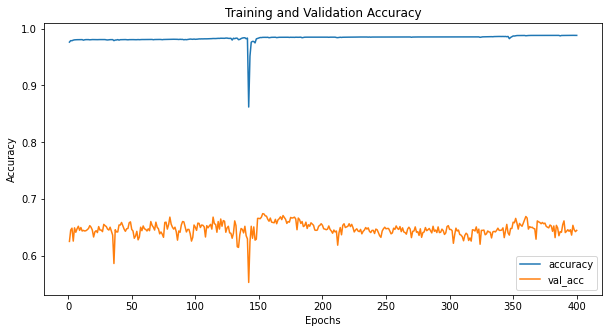

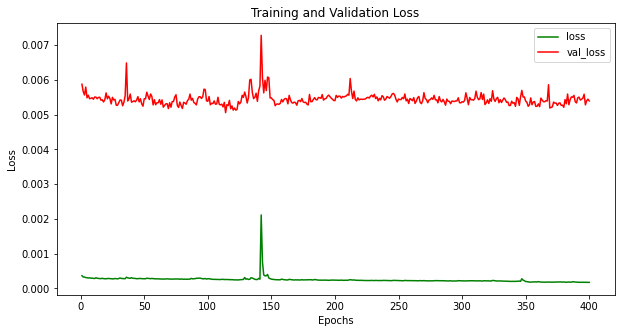

In [ ]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 2s 9ms/step


array([[44,  0,  0, ...,  0,  0,  0],
       [ 0, 57,  0, ...,  0,  0,  0],
       [ 0,  0, 65, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 67,  0],
       [ 0,  0,  0, ...,  0,  0, 57]])

In [ ]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       59.0
1       68.0
2       72.0
3        2.0
4       57.0
        ... 
5995     3.0
5996    87.0
5997    40.0
5998    68.0
5999    37.0
Name: y_test, Length: 6000, dtype: float64

In [ ]:
# ch1 = pd.DataFrame(np.rint(y_pred))
# for i in range(1,101):
#   ch1.loc[ch1[i] == 1.0 , 'pred'] = i 

 
#predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [ ]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,59.0
1,68.0
2,72.0
3,2.0
4,57.0
...,...
5995,3.0
5996,87.0
5997,40.0
5998,68.0


In [ ]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [ ]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [ ]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
30,0.001909,0.008317,0.014489,0.020412,0.025995,0.031137,0.035801,0.040075,0.044195,0.048538,...,0.044631,0.050399,0.057432,0.066046,0.076371,0.088327,0.101648,85.0,36.0,no
46,0.096114,0.095362,0.095047,0.095447,0.096676,0.098677,0.101247,0.104083,0.106844,0.109202,...,-0.004398,-0.008214,-0.013081,-0.019006,-0.025674,-0.032320,-0.037693,83.0,80.0,no
54,-0.041972,-0.048778,-0.055266,-0.061636,-0.067728,-0.073065,-0.076978,-0.078796,-0.078050,-0.074630,...,-0.102289,-0.108650,-0.114708,-0.119718,-0.122885,-0.123496,-0.121095,20.0,71.0,no
55,0.050686,0.056807,0.061922,0.066330,0.070463,0.074831,0.079964,0.086349,0.094365,0.104239,...,0.125449,0.136371,0.147691,0.159697,0.172642,0.186692,0.201860,41.0,50.0,no
71,-0.511413,-0.507140,-0.469849,-0.408462,-0.333769,-0.256404,-0.185178,-0.126038,-0.081724,-0.052058,...,0.031533,0.034874,0.038518,0.042180,0.045745,0.049241,0.052764,4.0,93.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.005315,-0.043084,-0.083200,-0.110473,-0.122973,-0.121490,-0.109050,-0.090022,-0.069069,-0.050204,...,-0.027012,-0.029614,-0.031356,-0.033020,-0.035244,-0.038329,-0.042129,95.0,23.0,no
5981,-0.005281,-0.018280,-0.031669,-0.042939,-0.050464,-0.053648,-0.052817,-0.048958,-0.043371,-0.037307,...,-0.016826,-0.013496,-0.011275,-0.010594,-0.011830,-0.015208,-0.020697,52.0,40.0,no
5992,-0.084734,-0.091664,-0.098196,-0.101411,-0.098148,-0.085744,-0.062829,-0.030004,0.009808,0.051498,...,0.072150,0.081214,0.090895,0.101388,0.112932,0.125713,0.139775,100.0,83.0,no
5994,0.008461,0.011468,0.012707,0.012096,0.009875,0.006558,0.002841,-0.000513,-0.002782,-0.003375,...,-0.048723,-0.051678,-0.052151,-0.050205,-0.046318,-0.041326,-0.036264,95.0,49.0,no
